In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using MDToolbox
using CUDA
using BenchmarkTools
using EzXML
using CUDA.Adapt
ENV["COLUMNS"] = 130

130

In [2]:
@show collect(devices())
@show device!(0)
@show device()

collect(devices()) = CuDevice[CuDevice(0), CuDevice(1)]
device!(0) = CuDevice(0)
device() = CuDevice(0)


CuDevice(0): Quadro RTX 8000

In [3]:
pdb_filepath = "./alanine-dipeptide-nowater.pdb"
traj_dir = "./traj"
ff_dir = "./forcefield"
njobs = 7

target_traj_path = "./traj/traj8.dcd"
target_ff_filepath = "./forcefield/sim_8.xml"

const precision_type = Float64

Float64

In [4]:
#pythonのmdtrajのインデックスに+1してる
atom_pairs = [6 17]           #距離を計算する原子のペア
phi_indices = [5, 7, 9, 15]   #二面角ϕ
psi_indices = [7, 9, 15, 17]  #二面角ψ

#xmlファイルでのatom type
phi_atom_type = ["C", "N", "CT", "C"]
psi_atom_type = ["N", "CT", "C", "N"]

4-element Vector{String}:
 "N"
 "CT"
 "C"
 "N"

In [5]:
top = readpdb(pdb_filepath)
ta = mdload(target_traj_path, top=top)

for i in 1:length(top.atomid)
    println("atomid = $(top.atomid[i]), atomname = $(top.atomname[i])")
end
println()
#sanity check
@show ta[:,vec(atom_pairs)].atomname
@show ta[:, phi_indices].atomname
@show ta[:, psi_indices].atomname

atomid = 1, atomname = HH31
atomid = 2, atomname = CH3
atomid = 3, atomname = HH32
atomid = 4, atomname = HH33
atomid = 5, atomname = C
atomid = 6, atomname = O
atomid = 7, atomname = N
atomid = 8, atomname = H
atomid = 9, atomname = CA
atomid = 10, atomname = HA
atomid = 11, atomname = CB
atomid = 12, atomname = HB1
atomid = 13, atomname = HB2
atomid = 14, atomname = HB3
atomid = 15, atomname = C
atomid = 16, atomname = O
atomid = 17, atomname = N
atomid = 18, atomname = H
atomid = 19, atomname = CH3
atomid = 20, atomname = HH31
atomid = 21, atomname = HH32
atomid = 22, atomname = HH33

(ta[:, vec(atom_pairs)]).atomname = ["O", "N"]
(ta[:, phi_indices]).atomname = ["C", "N", "CA", "C"]
(ta[:, psi_indices]).atomname = ["N", "CA", "C", "N"]


4-element Vector{String}:
 "N"
 "CA"
 "C"
 "N"

## input target traj

In [6]:
phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
dihedral_target = hcat(phi, psi)
distance_target = compute_distance(ta, atom_pairs) ./ 10

100000×1 Matrix{Float64}:
 0.4557272880032969
 0.3969620583928402
 0.40588421074375114
 0.45621472385467204
 0.3968975288671349
 0.41259354688401484
 0.4082375838915252
 0.404707033552233
 0.48863684289583753
 0.4152569827392904
 0.445251529434913
 0.3759139012473771
 0.37227408007451934
 ⋮
 0.40446336908483016
 0.5050478534369355
 0.3851853285293964
 0.4160895075690319
 0.3958587682847585
 0.4116100352112199
 0.4440289623113752
 0.398664211967022
 0.47490291274157925
 0.3893070333917464
 0.4591289142820673
 0.4492650034805128

## input traj

In [7]:
dihedral_k = Array{Array{Float64}}(undef, njobs)
distance_k = Array{Array{Float64}}(undef, njobs)

for i in 1:njobs
    traj_filepath = joinpath(traj_dir, "traj$(i).dcd")
    ta = mdload(traj_filepath, top=top)

    phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
    psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
    dihedral_k[i] = hcat(phi, psi)
    
    distance = compute_distance(ta, atom_pairs) ./ 10 #おそらくこれでnmに変換してる
    distance_k[i] = distance
end

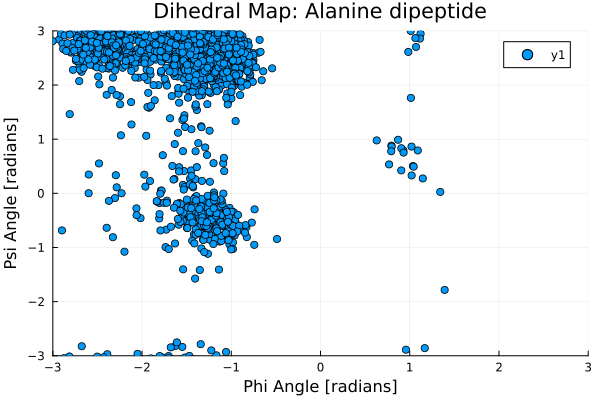

In [8]:
plot(dihedral_target[1:50:end, 1], dihedral_target[1:50:end, 2], st=scatter,
    xlabel="Phi Angle [radians]", ylabel="Psi Angle [radians]", title=("Dihedral Map: Alanine dipeptide"),
    xlim=(-3,3),ylim=(-3,3))

## distance distribution

In [9]:
"""
    calc_histogram(a::AbstractVector; 
                    rng=nothing, 
                    bin_width=0.005, 
                    nbins=nothing, 
                    density::Bool=false, 
                    weights::AbstractArray=[])

Calculate a histogram of the input data `a`.

# Arguments
- `a::AbstractVector`: Input data vector.
- `rng::Tuple{Real, Real}`: Range of values to consider for the histogram. If not provided, the minimum and maximum values of `a` will be used.
- `bin_width::Real=0.005`: Width of each histogram bin.
- `nbins::Integer`: Number of bins for the histogram. If not provided, it will be automatically calculated based on `rng` and `bin_width`.
- `density::Bool=false`: If `true`, normalize the histogram to form a probability density.
- `weights::AbstractArray=[]`: Optional weights associated with each data point.

# Returns
- `hist::Array{Float64,1}`: Counts of data points in each bin.
- `bin_edges::Array{Float64,1}`: Edges of the bins.

# Examples
```julia-repl
julia> data = randn(1000)  # Generate random data
julia> hist, bin_edges = calc_histogram(data, rng=(-3, 3), bin_width=0.1, density=true)
```
"""
function calc_histogram(a::AbstractVector;
                    rng=nothing, 
                    bin_width=0.005, # nm
                    nbins=nothing, 
                    density::Bool=false, 
                    weights::AbstractArray=[])
    
    # If range is not specified, use the range of the data
    if rng == nothing
        rng = (minimum(a), maximum(a))
    end

    # If data falls outside the specified range, ignore it
    a = filter(x -> rng[1] <= x && x <= rng[2], a)
    
    # If nbins is not specified, calculate it based on the bin width
    if nbins == nothing
        nbins = ceil(Int, (rng[2] - rng[1]) / bin_width)
    else
        # Recalculate bin width based on nbins
        bin_width = (rng[2] - rng[1]) / nbins
    end
    
    # Initialize histogram bins
    hist = zeros(Float64, nbins)
    
    # Calculate bin edges
    bin_edges = range(rng[1], rng[2], nbins+1) |> Vector

    # Calculate bin centers
    bin_centers = (bin_edges[1:end-1] + bin_edges[2:end]) / 2
    
    # Fill histogram bins
    if isempty(weights)
        for val in a
            bin_index = argmin(abs.(bin_centers .- val))
            hist[bin_index] += 1
        end
    else
        for (val, weight) in zip(a, weights)
            bin_index = argmin(abs.(bin_centers .- val))
            hist[bin_index] += weight
        end
    end
    
    # Normalize by bin width and total weight if density is true
    if density
        hist ./= bin_width
        if !isempty(weights)
            total_weight = sum(weights)
            hist ./= total_weight
        end
    end
    
    return hist, bin_edges
end

calc_histogram

In [10]:
?calc_histogram

search: calc_histogram



```
calc_histogram(a::AbstractVector; 
                rng=nothing, 
                bin_width=0.005, 
                nbins=nothing, 
                density::Bool=false, 
                weights::AbstractArray=[])
```

Calculate a histogram of the input data `a`.

# Arguments

  * `a::AbstractVector`: Input data vector.
  * `rng::Tuple{Real, Real}`: Range of values to consider for the histogram. If not provided, the minimum and maximum values of `a` will be used.
  * `bin_width::Real=0.005`: Width of each histogram bin.
  * `nbins::Integer`: Number of bins for the histogram. If not provided, it will be automatically calculated based on `rng` and `bin_width`.
  * `density::Bool=false`: If `true`, normalize the histogram to form a probability density.
  * `weights::AbstractArray=[]`: Optional weights associated with each data point.

# Returns

  * `hist::Array{Float64,1}`: Counts of data points in each bin.
  * `bin_edges::Array{Float64,1}`: Edges of the bins.

# Examples

```julia-repl
julia> data = randn(1000)  # Generate random data
julia> hist, bin_edges = calc_histogram(data, rng=(-3, 3), bin_width=0.1, density=true)
```


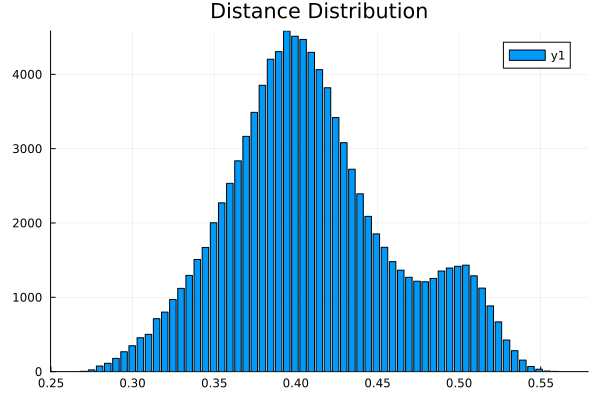

In [11]:
hist, bin_edges = calc_histogram(vec(distance_target))
bin_centers = (bin_edges[1:end-1] + bin_edges[2:end]) / 2
plot(bin_centers, hist, st=bar, title="Distance Distribution")

In [12]:
"""
    ksdensity_from_histogram(hist::AbstractVector, bin_edges::AbstractVector; 
                             weights::AbstractVector = ones(length(hist)), 
                             bandwidth::Real=0.1, num_points::Int=1000)

    Calculate kernel density estimate from histogram.

    Parameters:
    - `hist`: Histogram counts.
    - `bin_edges`: Bin edges.
    - `weights`: Weights for each bin (default: ones).
    - `bandwidth`: Bandwidth of the kernel (default: 0.1).
    - `num_points`: Number of points in the density estimate (default: 1000).

    Returns:
    - `x_grid_dense`: Grid of points for the density estimate.
    - `density_estimate`: Density estimate corresponding to `x_grid_dense`.
"""
function ksdensity_from_histogram(hist::AbstractVector, bin_edges::AbstractVector; 
                                  weights::AbstractVector = ones(length(hist)), 
                                  bandwidth::Real=0.1, num_points::Int=1000)
    # Construct density estimate grid
    x_grid = []
    for i in 1:length(bin_edges)-1
        push!(x_grid, range(bin_edges[i], bin_edges[i+1], length=round(Int, hist[i])))
    end
    x_grid = vcat(x_grid...)
    
    # Construct dense grid for density estimate
    x_grid_dense = range(minimum(x_grid), maximum(x_grid), length=num_points)
    
    # Compute density estimate
    density_estimate = zeros(length(x_grid_dense))
    for i in 1:length(hist)
        density_estimate .+= hist[i] * weights[i] * exp.(-((x_grid_dense .- bin_edges[i]) ./ bandwidth).^2 / 2) / (bandwidth * sqrt(2 * π))
    end
    
    return x_grid_dense, density_estimate
end

ksdensity_from_histogram

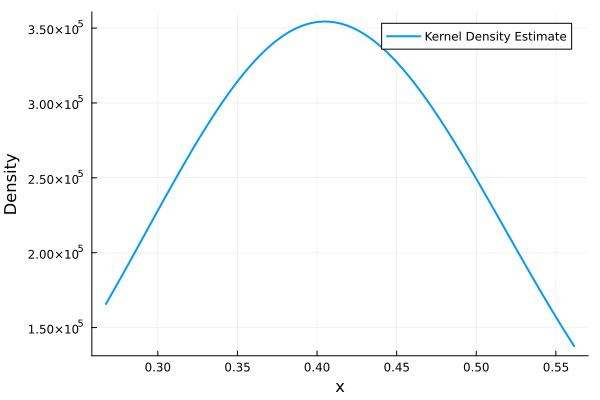

In [13]:
x_grid_dense, density_estimate = ksdensity_from_histogram(hist, bin_edges,)
plot(x_grid_dense, density_estimate, label="Kernel Density Estimate", xlabel="x", ylabel="Density", linewidth=2)

## input forcefield parameter

In [14]:
#二面角ϕ,ψに関連するパラメータはn,θ_zero,kの３つ
#最適化を目指すのはk

abstract type AbstractParam end

struct ParamCPU{T<:AbstractFloat}<:AbstractParam
    n::Vector{T}
    theta_zero::Vector{T}
    k::Vector{T}
end

struct Param{T<:AbstractFloat}<:AbstractParam
    n::CuArray{T}
    theta_zero::CuArray{T}
    k::CuArray{T}
end

function init_Param(ff_array::AbstractVector, gpu::Bool=false, T::DataType=Float64)
    n = T[]
    theta_zero = T[]
    k = T[]
    
    for line in ff_array
        #println(line)      
        if(occursin(r"type.*", line[1]))
            continue
        elseif(occursin(r"periodicity.*", line[1]))
            push!(n, parse(T, line[2]))
        elseif(occursin(r"phase.*", line[1]))
            push!(theta_zero, parse(T, line[2]))
        elseif(occursin(r"k.*", line[1]))
            push!(k, parse(T, line[2]))
        else
            println("ERROR")
        end
    end
    
    if(gpu) 
        n = adapt(CuArray, n)
        theta_zero = adapt(CuArray, theta_zero)
        k = adapt(CuArray, k)
        ff_param = Param(n, theta_zero, k)
        return ff_param
    end
    
    ff_param = ParamCPU(n, theta_zero, k)
    return ff_param
end

init_Param (generic function with 3 methods)

In [15]:
#力場ファイルから対象のパラメータを返す関数
function input_ff(ff_filepath; gpu=false::Bool)
    xml = readxml(ff_filepath)
    xmlroot = root(xml)
    
    children = elements(xmlroot)
    children_name = nodename.(children)
    torsion_index = children_name .== "PeriodicTorsionForce"
    torsion = children[torsion_index][1]
    
    phi_atom_type = ["C", "N", "CT", "C"]
    psi_atom_type = ["N", "CT", "C", "N"]
    
    ff_phi = []
    ff_psi = []
    for ff_params in eachelement(torsion)
        params_name = [nodename(i) for i in eachattribute(ff_params)]
        params_content = [nodecontent(i) for i in eachattribute(ff_params)]
        #println(params_content[1:4])
        if(params_content[1:4] == phi_atom_type)
            ff_phi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
        if(params_content[1:4] == psi_atom_type)
            ff_psi = [(params_name[i], params_content[i]) for i in 1:length(params_name)]
        end
    end

    return init_Param(ff_phi, gpu), init_Param(ff_psi, gpu)
end

input_ff (generic function with 1 method)

In [16]:
ff_phi_k = Array{ParamCPU}(undef, njobs)
ff_psi_k = Array{ParamCPU}(undef, njobs)

for i in 1:njobs
    ff_filepath = joinpath(ff_dir, "sim_$(i).xml")
    ff_phi_k[i], ff_psi_k[i] = input_ff(ff_filepath)
end

#input target ff
ff_phi_target, ff_psi_target = input_ff(target_ff_filepath, gpu=true)

(Param{Float64}([1.0, 2.0, 3.0, 4.0, 2.0], [0.0, 0.0, 0.0, 0.0, 1.5707963267948966], [-0.14163188994724013, 1.467941446152554, 2.257861668812834, 0.32324481895832313, 1.5995961659045077]), Param{Float64}([1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 1.0, 2.0, 3.0, 4.0, 5.0], [2.8080339837817268, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966], [2.6351371502810945, -0.8166651298560587, 5.976334813143396, 2.0119128492685574, -0.07485608032517561, -0.015644074546155885, -1.0431139293703353, 0.2995220759368923, 0.2297132337140822, 0.10157013468325342, -0.04504330406243621]))

In [17]:
#二面角のポテンシャルの計算
@inline function compute_dihedral_energy(theta::AbstractFloat, n::AbstractFloat, 
        theta_zero::AbstractFloat, k::AbstractFloat)
    return k * (1 + cos(n * theta - theta_zero))
end

function sum_compute_dihedral_energy(theta::AbstractFloat, ff_param::AbstractParam)
    return sum(compute_dihedral_energy.(theta, ff_param.n, ff_param.theta_zero, ff_param.k))
end

sum_compute_dihedral_energy (generic function with 1 method)

In [18]:
#compute u_kl
K = njobs
N_k = Array{Int}(undef, K)
for k in 1:K
    N_k[k] = length(distance_k[k])
end
KBT = KB_kcalpermol * 300
beta = Float64(1.0/(KBT))

u_kl = Array{Array{Float64}}(undef, (K, K))
for k in 1:K
    for l in 1:K
        u_kl[k, l] = map(i -> beta * sum_compute_dihedral_energy(dihedral_k[k][i, 1], ff_phi_k[l]) 
            + beta * sum_compute_dihedral_energy(dihedral_k[k][i, 2], ff_psi_k[l]), 1:N_k[k])
    end
end

In [19]:
f_k = Float64.(MDToolbox.mbar(u_kl))

iteration = 1  delta = 1.484984e+00  tol = 1.000000e-08
free energies =  0.000000 0.218658 0.285121 0.192046 -0.061469 0.294720 -0.224850

iteration = 2  delta = 2.643537e-02  tol = 1.000000e-08
free energies =  0.000000 0.223437 0.288206 0.186740 -0.061557 0.298316 -0.228850

iteration = 3  delta = 1.153944e-03  tol = 1.000000e-08
free energies =  0.000000 0.223610 0.288307 0.186508 -0.061552 0.298436 -0.228994

iteration = 4  delta = 4.449107e-05  tol = 1.000000e-08
free energies =  0.000000 0.223616 0.288311 0.186499 -0.061552 0.298441 -0.228999

iteration = 5  delta = 1.703697e-06  tol = 1.000000e-08
free energies =  0.000000 0.223617 0.288311 0.186499 -0.061552 0.298441 -0.229000

iteration = 6  delta = 6.521289e-08  tol = 1.000000e-08
free energies =  0.000000 0.223617 0.288311 0.186499 -0.061552 0.298441 -0.229000

iteration = 7  delta = 2.496113e-09  tol = 1.000000e-08
free energies =  0.000000 0.223617 0.288311 0.186499 -0.061552 0.298441 -0.229000

iteration = 8  delta = 9.55

7-element Vector{Float64}:
  0.0
  0.22361659068053039
  0.2883107637696799
  0.18649853192986762
 -0.06155208112477491
  0.2984406890063645
 -0.22899952645057706

## send from the CPU to the GPU

In [20]:
dihedral_k = adapt(Vector{CuArray}, dihedral_k)
distance_k = adapt(Vector{CuArray}, distance_k)
dihedral_target = adapt(CuArray, dihedral_target)
distance_target = adapt(CuArray, distance_target)

u_kl = adapt(Matrix{CuArray}, u_kl)

function send_gpu_param(ff_param::AbstractParam)
    if(typeof(ff_param) == Param)
        return ff_param
    end
    ff_param_gpu = Param(adapt(CuArray, ff_param.n), adapt(CuArray, ff_param.theta_zero), adapt(CuArray, ff_param.k))
    return ff_param_gpu
end

ff_phi_k = map(send_gpu_param, ff_phi_k)
ff_psi_k = map(send_gpu_param, ff_psi_k)

ff_phi_target = send_gpu_param(ff_phi_target)
ff_psi_target = send_gpu_param(ff_psi_target)

Param{Float64}([1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 1.0, 2.0, 3.0, 4.0, 5.0], [2.8080339837817268, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966], [2.6351371502810945, -0.8166651298560587, 5.976334813143396, 2.0119128492685574, -0.07485608032517561, -0.015644074546155885, -1.0431139293703353, 0.2995220759368923, 0.2297132337140822, 0.10157013468325342, -0.04504330406243621])

## GPU kernel

In [21]:
#u_kを計算するための関数
function compute_u_kernel!(beta::T, dihedral::CuDeviceArray{T}, 
        n_phi::CuDeviceArray{T}, theta_zero_phi::CuDeviceArray{T}, k_phi::CuDeviceArray{T}, 
        n_psi::CuDeviceArray{T}, theta_zero_psi::CuDeviceArray{T}, k_psi::CuDeviceArray{T}, u::CuDeviceArray{T}) where {T}
    
    N = size(dihedral, 1)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    phi_param_num = length(k_phi)
    psi_param_num = length(k_psi)

    for i in index:stride:N
        for j in 1:phi_param_num
            u[i] += beta * compute_dihedral_energy(dihedral[i, 1], n_phi[j], theta_zero_phi[j], k_phi[j])
        end
        for j in 1:psi_param_num
            u[i] += beta * compute_dihedral_energy(dihedral[i, 2], n_psi[j], theta_zero_psi[j], k_psi[j])
        end
    end

    return nothing
end

function compute_u_k(beta::T, dihedral_k::Vector{<:CuArray},
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    K = length(dihedral_k)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = Vector{CuArray{T}}(undef, K)
    
    for k in 1:K
        nthreads = 256
        nblocks = ceil(Int, N_k[k] / nthreads)

        
        u_k[k] = adapt(CuArray, zeros(N_k[k]))
        @cuda threads=nthreads blocks=nblocks compute_u_kernel!(beta, dihedral_k[k], n_phi, theta_zero_phi, 
            k_phi, n_psi, theta_zero_psi, k_psi, u_k[k])
    end
    return u_k
end

function ChainRulesCore.rrule(::typeof(compute_u_k), beta::T, dihedral_k::Vector{<:CuArray}, 
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    
    K = size(dihedral_k, 1)
    N_k = Array{Int}(undef, K)
    for k in 1:K
        N_k[k] = size(dihedral_k[k], 1)
    end

    u_k = Vector{CuArray{T}}(undef, K)
    
    for k in 1:K
        nthreads = 256
        nblocks = ceil(Int, N_k[k] / nthreads)

        u_k[k] = adapt(CuArray, zeros(N_k[k]))
        @cuda threads=nthreads blocks=nblocks compute_u_kernel!(beta, dihedral_k[k], n_phi, theta_zero_phi, 
            k_phi, n_psi, theta_zero_psi, k_psi, u_k[k])
    end
    function compute_u_k_pullback(dU)
        dk_phi = similar(k_phi)
        dk_phi .= zero(Float64)
        dk_psi = similar(k_psi)
        dk_psi .= zero(Float64)
        
        for k = 1:K
            nthreads = 256
            nblocks = ceil(Int, N_k[k] / nthreads)
            @cuda threads=nthreads blocks=nblocks compute_u_pullback_aux!(dihedral_k[k], n_phi, theta_zero_phi, 
                n_psi, theta_zero_psi, dk_phi, dk_psi, dU[k])
        end
        return NoTangent(), NoTangent(), NoTangent(),
            NoTangent(), NoTangent(), dk_phi, NoTangent(), NoTangent(), dk_psi, NoTangent()
    end
    return u_k, compute_u_k_pullback
end

function compute_u_pullback_aux!(dihedral::CuDeviceArray{U}, n_phi::CuDeviceArray{T}, theta_zero_phi::CuDeviceArray{T},
        n_psi::CuDeviceArray{T}, theta_zero_psi::CuDeviceArray{T}, 
        dk_phi::CuDeviceArray{T}, dk_psi::CuDeviceArray{T}, dU::CuDeviceArray{T}) where {T, U}
    
    N = size(dihedral, 1)

    phi_param_num = length(n_phi)
    psi_param_num = length(n_psi)

    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    for i in index:stride:N
        for j in 1:phi_param_num
            dk_phi[j] += (1.0 + cos(n_phi[j] * dihedral[i, 1] - theta_zero_phi[j])) * dU[i]
        end
        for j in 1:psi_param_num
            dk_psi[j] += (1.0 + cos(n_psi[j] * dihedral[i, 2] - theta_zero_psi[j])) * dU[i]
        end
    end
    return nothing
end

compute_u_pullback_aux! (generic function with 1 method)

In [22]:
#w_kを計算する関数
function mbar_weight_gpu(u_kl::AbstractArray{<:CuArray}, f_k::AbstractArray{T}, u_k::AbstractArray{<:CuArray{T}}=nothing) where {T}
    K, L = size(u_kl)

    # N_k: number of data in k-th umbrella window
    N_k = zeros(Int64, K)
    for k = 1:K
        N_k[k] = length(u_kl[k, 1])
    end
    N_max = maximum(N_k)
    
    # conversion from array of array (u_kl) to array (u_kln)
    u_kln = adapt(CuArray, zeros(Float64, K, K, N_max))
    for k = 1:K
        for l = 1:K
            u_kln[k, l, 1:N_k[k]] .= u_kl[k, l]
        end
    end
    
    u_kn = adapt(CuArray, zeros(Float64, K, N_max))
    for k = 1:K
        if u_k === nothing
            u_kn[1, 1:N_k[k]] .= adapt(CuArray, zero(Float64))
        else
            u_kn[k, 1:N_k[k]] .= u_k[k]
        end
    end
    
    log_w_kn = adapt(CuArray, zeros(Float64, K, N_max))
    for k = 1:K
        log_w_kn[k, 1:N_k[k]] .= 1.0
    end
    idx = log_w_kn .> 0.5
    
    log_w_kn = mbar_log_wi_jn_gpu(N_k, f_k, u_kln, u_kn, K, N_max)
    log_w_n  = log_w_kn[idx]

    s = MDToolbox.logsumexp_1d(log_w_n)
    w_k = Vector{CuArray{Float64}}(undef, K)
    for k = 1:K
        w_k[k] = exp.((log_w_kn[k, 1:N_k[k]] .- s))
    end

    return w_k
end

function ChainRulesCore.rrule(::typeof(mbar_weight_gpu), 
        u_kl::AbstractArray{<:CuArray}, f_k::AbstractArray{T}, u_k::AbstractArray{<:CuArray{T}}) where {T}
    w_k = mbar_weight_gpu(u_kl, f_k, u_k)
    K = size(u_kl, 1)
    du_k = deepcopy(w_k)
    N = length(w_k[1])
    nthreads = 256
    nblocks = ceil(Int, N / nthreads)
    function mbar_weight_gpu_pullback(dw_k)
        for k = 1:K
            @cuda threads=nthreads blocks=nblocks mbar_weight_pullback_aux!(w_k[k], dw_k[k], du_k[k])
        end
        return NoTangent(), ZeroTangent(), NoTangent(), du_k
    end
    return w_k, mbar_weight_gpu_pullback
end

function mbar_weight_pullback_aux!(w::CuDeviceArray{T}, dw::CuDeviceArray{T}, du::CuDeviceArray{T}) where {T}
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    N = length(w)
    for i = index:stride:N
        du[i] = dw[i] * (-w[i])
    end

    return nothing
end

mbar_weight_pullback_aux! (generic function with 1 method)

In [23]:
function mbar_log_wi_jn_gpu(N_k::AbstractArray{U}, f_k::AbstractArray{T}, 
        u_kln::CuArray{T}, u_kn::CuArray{T}, K::Int64, N_max::Int64) where {T, U}
    log_wi_jn = adapt(CuArray, zeros(Float64, (K, N_max)))
    for k = 1:K
        tmp = adapt(CuArray, repeat(log.(N_k), 1, N_k[k]) .+ repeat(f_k, 1, N_k[k]))
        x = tmp .- (u_kln[k, :, 1:N_k[k]] .- repeat(u_kn[k:k, 1:N_k[k]], K, 1))
        log_wi_jn[k:k, 1:N_k[k]] .= - MDToolbox.logsumexp_over_row(x)
    end
    return log_wi_jn
end

mbar_log_wi_jn_gpu (generic function with 1 method)

In [24]:
CUDA.@allowscalar(false)
u_k = compute_u_k(beta, dihedral_k, 
    ff_phi_target.n, ff_phi_target.theta_zero, ff_phi_target.k,
    ff_psi_target.n, ff_psi_target.theta_zero, ff_psi_target.k)

w_k = mbar_weight_gpu(u_kl, f_k, u_k)

7-element Vector{CuArray{Float64}}:
 [1.4848336593542427e-6, 1.7286986245323608e-6, 1.4642481838444953e-6, 1.3810988806406122e-6, 1.5212104757444909e-6, 1.8505917744787792e-6, 1.2070660060881691e-6, 1.4941928044440225e-6, 1.3527963412940576e-6, 1.3231252948745786e-6  …  1.4572196788103317e-6, 1.3203338370321042e-6, 1.5250013985933434e-6, 1.4008219686817273e-6, 1.8275719189456723e-6, 1.4539199442563938e-6, 1.679781423450673e-6, 1.5174349518900105e-6, 1.7522965220881247e-6, 1.4645497331259428e-6]
 [1.7805647067738343e-6, 1.4910865539298146e-6, 1.3653876960286392e-6, 1.4316434714090543e-6, 1.4784342670187821e-6, 1.4724386707176793e-6, 1.3293930405848814e-6, 1.5889203876521797e-6, 1.5010290286174448e-6, 1.7091150231364532e-6  …  1.2771087143295766e-6, 1.4548312540894025e-6, 1.5583433004163012e-6, 1.4140605086500531e-6, 1.879298259290939e-6, 1.3147877569404943e-6, 1.3300657960760619e-6, 1.3215815021640455e-6, 1.5206036344740947e-6, 9.830594747294359e-7]
 [1.4789917328392572e-6, 9.4792116422

## train

In [25]:
#重み付けした熱力学量を計算する関数
#Σ(wₖₙ * Aₖₙ)

function compute_averaged_property(A_k::AbstractArray{<:CuArray}, dihedral_k::AbstractArray{<:CuArray}, 
        f_k::AbstractArray{T}, u_kl::AbstractArray{<:CuArray}, 
        beta::T, n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T}, 
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    
    K = size(A_k, 1)
    u_k = Vector{CuArray{T}}(undef, K)
    u_k = compute_u_k(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)

    w_k = mbar_weight_gpu(u_kl, f_k, u_k)

    A_target = 0.0
    for k in 1:K
        A_target += sum(w_k[k] .* A_k[k])
    end
    return A_target
end

compute_averaged_property (generic function with 1 method)

In [26]:
#n_effを計算する関数 (Σwₖ)² / Σ(wₖ²)

function compute_n_eff(w_k::AbstractVector{T}) where {T}
    K = size(w_k, 1)
    N = size(w_k[1], 1)

    n_eff = sum(map(i -> sum(w_k[i]), 1:K)) ^ 2 / sum(map(i -> sum(w_k[i] .^ 2), 1:K))
    return n_eff
end

function compute_n_eff(dihedral_k::AbstractArray{<:CuArray}, f_k::AbstractArray{T},
        u_kl::AbstractArray{<:CuArray}, beta::T,
        n_phi::CuArray{T}, theta_zero_phi::CuArray{T}, k_phi::CuArray{T},
        n_psi::CuArray{T}, theta_zero_psi::CuArray{T}, k_psi::CuArray{T}) where {T}
    
    K = size(dihedral_k, 1)
    u_k = Vector{CuArray{T}}(undef, K)
    u_k = compute_u_k(beta, dihedral_k, n_phi, theta_zero_phi,
        k_phi, n_psi, theta_zero_psi, k_psi)

    w_k = mbar_weight_gpu(u_kl, f_k, u_k)
    n_eff = compute_n_eff(w_k)
    return n_eff
end

compute_n_eff (generic function with 2 methods)

In [27]:
X_train = distance_k #距離の軌跡
y_train = mean(distance_target) #ターゲットの距離の平均

struct Energy{T<:AbstractArray}
    P::T #P[1] = k_phi, P[2] = k_psi
end

Flux.@functor Energy (P,)

(m::Energy)(X::AbstractArray{<:CuArray}) =compute_averaged_property(X, dihedral_k, f_k, 
        u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero, m.P[1], 
        ff_psi_target.n, ff_psi_target.theta_zero, m.P[2])

loss(x, y) = Flux.Losses.mse(x::AbstractFloat, y::AbstractFloat)

loss (generic function with 1 method)

In [28]:
#sanity check
m = Energy([ff_phi_target.k, ff_psi_target.k])
loss(m(X_train), y_train)

4.735697344786148e-6

In [29]:
m = Energy([deepcopy(ff_phi_k[1].k), deepcopy(ff_psi_k[1].k)])
loss(m(X_train), y_train)

2.7737440502737106e-8

In [30]:
#CUDA.@profile trace=false g = gradient(m -> loss(m(), y_train), m)[1]

In [31]:
function print_progress(epoch, loss, m, n_eff)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(m.P[1]), n_eff = $n_eff")
end

print_progress (generic function with 1 method)

In [32]:
k_phi_estimated_array = []
k_psi_estimated_array = []
n_eff_array = []

Any[]

In [33]:
CUDA.allowscalar(false)
loss_train = []
nepoch = 100
learning_rate = 1e-4
println("Initial loss: $(loss(m(X_train), y_train))")
println("Initial param: $(m.P[1])")
threshold = sum(N_k) / 2
t = Flux.Optimisers.setup(Adam(learning_rate), m) |> Flux.gpu

result, time = @timed for epoch in 1:nepoch

    g = gradient(m -> loss(m(X_train), y_train), m)[1]
    Flux.Optimisers.update!(t, m, g)
    
    L = loss(m(X_train), y_train)
    push!(loss_train, L)

    push!(k_phi_estimated_array, deepcopy(m.P[1]))
    push!(k_psi_estimated_array, deepcopy(m.P[2]))

    n_eff = compute_n_eff(dihedral_k, f_k, u_kl, beta, ff_phi_target.n, ff_phi_target.theta_zero,
        m.P[1], ff_psi_target.n, ff_psi_target.theta_zero, m.P[2])

    if (epoch % (nepoch / 10) == 0)
        print_progress(epoch, L, m, n_eff)
    end

    #終了判定
    if(n_eff < threshold)
        ###
    end
end

Initial loss: 2.7737440502737106e-8
Initial param: [-0.1396954369058983, 1.4020721749174487, 2.2722793075263983, 0.33249158784820976, 1.669819011164073]
Epoch: 10, loss: 7.296686225068165e-9
param: [-0.14028071589837793, 1.4016136597187168, 2.271719151224066, 0.3317855758540747, 1.6691847210635968], n_eff = 697830.5649214779
Epoch: 20, loss: 6.296194899514604e-10
param: [-0.14069422302577866, 1.4012938628215377, 2.2713227003492857, 0.3312646061467442, 1.6687307977723231], n_eff = 697725.1227292723
Epoch: 30, loss: 4.8495544189874e-11
param: [-0.14089994650244744, 1.4011417106051252, 2.271123032673631, 0.33099318581887943, 1.6684975221171625], n_eff = 697664.7323786452
Epoch: 40, loss: 2.4178386964660703e-10
param: [-0.14095316887609147, 1.4011019555813755, 2.271070743786721, 0.3309212761565752, 1.6684370680292844], n_eff = 697647.9712009176
Epoch: 50, loss: 1.2301405782231344e-10
param: [-0.14092640030643186, 1.4011185345308916, 2.2710948596539122, 0.33095733919450177, 1.66847020789781

(value = nothing, time = 40.568656302, bytes = 55618886367, gctime = 2.993948014, gcstats = Base.GC_Diff(55618886367, 9626, 0, 28837335, 13838, 10123, 2993948014, 311, 0))

In [34]:
a = Flux.throttle(() -> println("Flux"), 2)
for i = 1:4  # a called in alternate iterations
    a()
    sleep(1)
end

Flux
Flux


## result

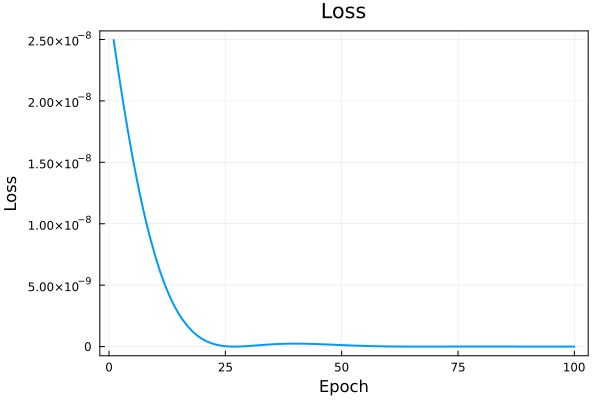

In [35]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2, title="Loss")
ylabel!("Loss")
xlabel!("Epoch")
#savefig(joinpath(figure_dir, "Loss_50step.png"))

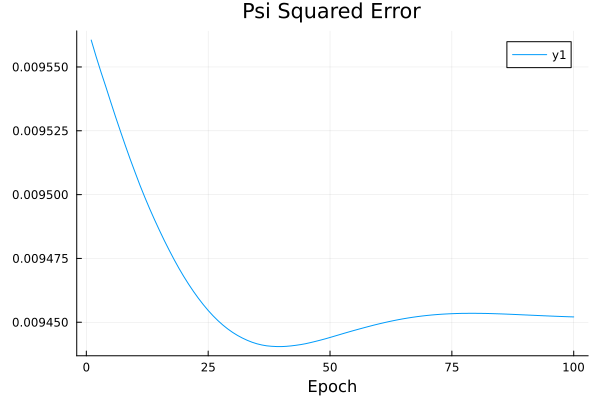

In [36]:
phi_dif = map(i -> (k_phi_estimated_array[i] - ff_phi_target.k) .^ 2, 1:nepoch) |> cpu
psi_dif = map(i -> (k_psi_estimated_array[i] - ff_psi_target.k) .^ 2, 1:nepoch) |> cpu

#二乗誤差
phi_squared_error = map(x -> sum(x), phi_dif)
psi_squared_error = map(x -> sum(x), psi_dif)

phi_dif = [[phi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_phi_target.k, 1)]
psi_dif = [[psi_dif[j][i] for j in 1:nepoch] for i in 1:size(ff_psi_target.k, 1)]

plot(phi_squared_error, xlabel="Epoch", title="Psi Squared Error")

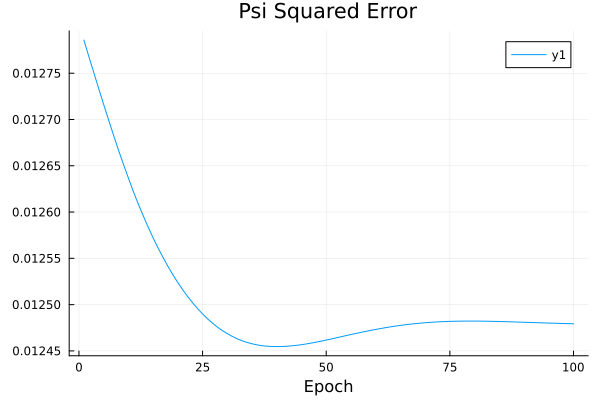

In [37]:
plot(psi_squared_error, xlabel="Epoch", title="Psi Squared Error")

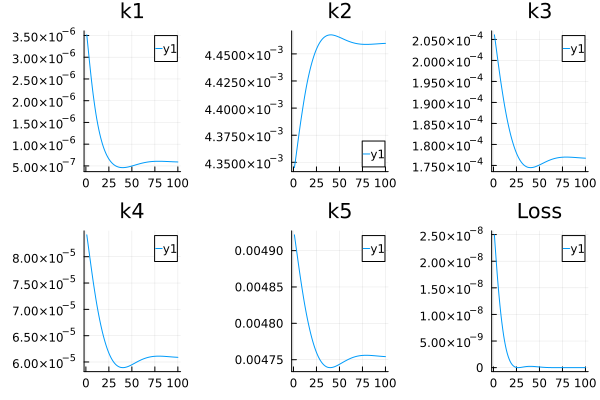

In [38]:
#k_phiと正解の二乗誤差
plt = []
for i in 1:size(ff_phi_target.k, 1)
    tmp = plot()
    plot!(tmp, phi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)

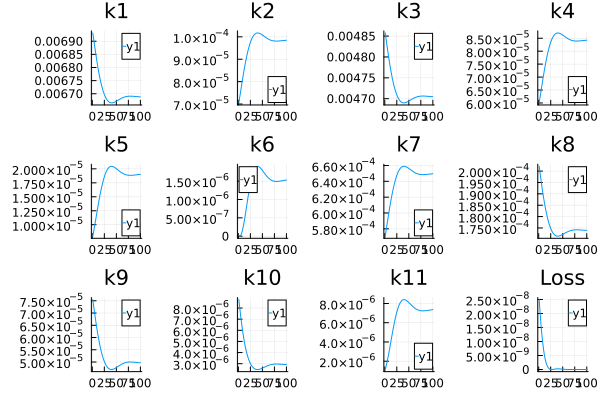

In [39]:
#k_psiと正解の二乗誤差
plt = []
for i in 1:size(ff_psi_target.k, 1)
    tmp = plot()
    plot!(tmp, psi_dif[i], title="k$i")
    push!(plt, tmp)
end
tmp = plot()
plot!(tmp, loss_train, title="Loss")
push!(plt, tmp)

plot(plt...)